# k-means with text data

In this project we will
* Cluster Wikipedia documents using k-means
* Explore the role of random initialization on the quality of the clustering
* Explore how results differ after changing the number of clusters
* Evaluate clustering, both quantitatively and qualitatively

When properly executed, clustering uncovers valuable insights from a set of unlabeled documents.

## Import necessary packages

In [1]:
from __future__ import print_function # to conform python 2.x print to python 3.x
import turicreate
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

%matplotlib inline

## Load data, extract features

To work with text data, we must first convert the documents into numerical features. As in the first project, let's extract TF-IDF features for each article.

In [2]:
wiki = turicreate.SFrame('people_wiki.sframe/')

In [19]:
wiki['tf_idf'] = turicreate.text_analytics.tf_idf(wiki['text'])

For the remainder of the project, we will use sparse matrices. Sparse matrices are matrices that have a small number of nonzero entries. A good data structure for sparse matrices would only store the nonzero entries to save space and speed up computation. SciPy provides a highly-optimized library for sparse matrices. Many matrix operations available for NumPy arrays are also available for SciPy sparse matrices.

We first convert the TF-IDF column (in dictionary format) into the SciPy sparse matrix format. We included plenty of comments for the curious; if we'd like, we may skip the next block and treat the function as a black box.

In [4]:
def sframe_to_scipy(x, column_name):
    '''
    Convert a dictionary column of an SFrame into a sparse matrix format where
    each (row_id, column_id, value) triple corresponds to the value of
    x[row_id][column_id], where column_id is a key in the dictionary.
       
    Example
    >>> sparse_matrix, map_key_to_index = sframe_to_scipy(sframe, column_name)
    '''
    assert type(x[column_name][0]) == dict, \
        'The chosen column must be dict type, representing sparse data.'
    
    # 1. Add a row number (id)
    x = x.add_row_number()

    # 2. Stack will transform x to have a row for each unique (row, key) pair.
    x = x.stack(column_name, ['feature', 'value'])

    # Map feature words to integers 
    unique_words = sorted(x['feature'].unique())
    mapping = {word:i for i, word in enumerate(unique_words)}
    x['feature_id'] = x['feature'].apply(lambda x: mapping[x])

    # Create numpy arrays that contain the data for the sparse matrix.
    row_id = np.array(x['id'])
    col_id = np.array(x['feature_id'])
    data = np.array(x['value'])
    
    width = x['id'].max() + 1
    height = x['feature_id'].max() + 1
    
    # Create a sparse matrix.
    mat = csr_matrix((data, (row_id, col_id)), shape=(width, height))
    return mat, mapping

In [5]:
%%time
# The conversion will take about a minute or two.
tf_idf, map_index_to_word = sframe_to_scipy(wiki, 'tf_idf')

CPU times: user 2min 49s, sys: 3.14 s, total: 2min 52s
Wall time: 35.3 s


The above matrix contains a TF-IDF score for each of the 59071 pages in the data set and each of the 547979 unique words.

In [21]:
tf_idf.shape

(59071, 547979)

## Normalize all vectors

As discussed in the previous project, Euclidean distance can be a poor metric of similarity between documents, as it unfairly penalizes long articles. For a reasonable assessment of similarity, we should disregard the length information and use length-agnostic metrics, such as cosine distance.

The k-means algorithm does not directly work with cosine distance, so we take an alternative route to remove length information: we normalize all vectors to be unit length. It turns out that Euclidean distance closely mimics cosine distance when all vectors are unit length. In particular, the squared Euclidean distance between any two vectors of length one is directly proportional to their cosine distance.

We can prove this as follows. Let $\mathbf{x}$ and $\mathbf{y}$ be normalized vectors, i.e. unit vectors, so that $\|\mathbf{x}\|=\|\mathbf{y}\|=1$. Write the squared Euclidean distance as the dot product of $(\mathbf{x} - \mathbf{y})$ to itself:
\begin{align*}
\|\mathbf{x} - \mathbf{y}\|^2 &= (\mathbf{x} - \mathbf{y})^T(\mathbf{x} - \mathbf{y})\\
                              &= (\mathbf{x}^T \mathbf{x}) - 2(\mathbf{x}^T \mathbf{y}) + (\mathbf{y}^T \mathbf{y})\\
                              &= \|\mathbf{x}\|^2 - 2(\mathbf{x}^T \mathbf{y}) + \|\mathbf{y}\|^2\\
                              &= 2 - 2(\mathbf{x}^T \mathbf{y})\\
                              &= 2(1 - (\mathbf{x}^T \mathbf{y}))\\
                              &= 2\left(1 - \frac{\mathbf{x}^T \mathbf{y}}{\|\mathbf{x}\|\|\mathbf{y}\|}\right)\\
                              &= 2\left[\text{cosine distance}\right]
\end{align*}

This tells us that two **unit vectors** that are close in Euclidean distance are also close in cosine distance. Thus, the k-means algorithm (which naturally uses Euclidean distances) on normalized vectors will produce the same results as clustering using cosine distance as a distance metric.

We import the [`normalize()` function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html) from scikit-learn to normalize all vectors to unit length.

In [7]:
from sklearn.preprocessing import normalize
tf_idf = normalize(tf_idf)

## Implement k-means

Let us implement the k-means algorithm. First, we choose an initial set of centroids. A common practice is to choose randomly from the data points.

**Note:** We specify a seed here, so that everyone gets the same answer. In practice, we highly recommend to use different seeds every time (for instance, by using the current timestamp).

In [8]:
def get_initial_centroids(data, k, seed=None):
    '''Randomly choose k data points as initial centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    n = data.shape[0] # number of data points
        
    # Pick K indices from range [0, N).
    rand_indices = np.random.randint(0, n, k)
    
    # Keep centroids as dense format, as many entries will be nonzero due to averaging.
    # As long as at least one document in a cluster contains a word,
    # it will carry a nonzero weight in the TF-IDF vector of the centroid.
    centroids = data[rand_indices,:].toarray()
    
    return centroids

After initialization, the k-means algorithm iterates between the following two steps:
1. Assign each data point to the closest centroid.
$$
z_i \gets \mathrm{argmin}_j \|\mu_j - \mathbf{x}_i\|^2
$$
2. Revise centroids as the mean of the assigned data points.
$$
\mu_j \gets \frac{1}{n_j}\sum_{i:z_i=j} \mathbf{x}_i
$$

In pseudocode, we iteratively do the following:
```
cluster_project = assign_clusters(data, centroids)
centroids = revise_centroids(data, k, cluster_project)
```

### Assigning clusters

How do we implement Step 1 of the main k-means loop above? First import `pairwise_distances` function from scikit-learn, which calculates Euclidean distances between rows of given arrays. See [this documentation](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_distances.html) for more information.

For the sake of demonstration, let's look at documents 100 through 102 as query documents and compute the distances between each of these documents and every other document in the corpus. In the k-means algorithm, we will have to compute pairwise distances between the set of centroids and the set of documents.

In [27]:
from sklearn.metrics import pairwise_distances

# Get the TF-IDF vectors for documents 100 through 102.
queries = tf_idf[100:102,:]

# Compute pairwise distances from every data point to each query vector.
dist = pairwise_distances(tf_idf, queries, metric='euclidean')

print(tf_idf[100][0])

  (0, 7743)	0.042126442880630596
  (0, 10736)	0.03225975352845338
  (0, 11157)	0.031148072709135097
  (0, 11571)	0.035522044116893095
  (0, 15800)	0.02658752356222188
  (0, 23058)	0.01805906759017193
  (0, 24595)	0.01905807345181327
  (0, 26035)	0.02146272787308414
  (0, 41740)	0.00040339733995718274
  (0, 42695)	0.07312097201850956
  (0, 42730)	0.11830737360655577
  (0, 46871)	0.07671625625521583
  (0, 46883)	0.03942782567862147
  (0, 48303)	0.07087878017179096
  (0, 48310)	0.169058493921619
  (0, 48903)	0.011298840024283753
  (0, 49080)	0.028540181795331954
  (0, 49325)	0.056764665290835195
  (0, 49887)	0.05563275776939529
  (0, 50293)	0.07126353628000587
  (0, 50318)	0.1332982589222607
  (0, 50475)	0.05521654592807544
  (0, 54411)	0.05313779316013941
  (0, 54412)	0.05758350798528349
  (0, 55638)	0.0769655336867853
  :	:
  (0, 489718)	0.022725384052337576
  (0, 490813)	0.03569130928861616
  (0, 494272)	0.006740288765279829
  (0, 494683)	0.03400894929978026
  (0, 496314)	0.04014875201

More formally, `dist[i,j]` is assigned the distance between the `i`th row of `X` (i.e., `X[i,:]`) and the `j`th row of `Y` (i.e., `Y[j,:]`).

**Checkpoint:** For a moment, suppose that we initialize three centroids with the first 3 rows of `tf_idf`. Write code to compute distances from each of the centroids to all data points in `tf_idf`. Then find the distance between row 430 of `tf_idf` and the second centroid and save it to `dist`.

In [31]:
cent = tf_idf[:3,:]

dist = pairwise_distances(cent[1], tf_idf[430], metric = 'euclidean')
pairwise_distances(cent, tf_idf, metric = 'euclidean')

array([[0.        , 1.40775177, 1.38784582, ..., 1.37070999, 1.35214578,
        1.40799024],
       [1.40775177, 0.        , 1.39867641, ..., 1.40978937, 1.41306211,
        1.41353429],
       [1.38784582, 1.39867641, 0.        , ..., 1.40616385, 1.40869799,
        1.40903605]])

In [29]:
'''Test cell'''
if np.allclose(dist, pairwise_distances(tf_idf[430,:], tf_idf[1,:])):
    print('Pass')
else:
    print('Check our code again')

Pass


**Checkpoint:** Next, given the pairwise distances, we take the minimum of the distances for each data point. Fittingly, NumPy provides an `argmin` function. See [this documentation](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.argmin.html) for details.

Read the documentation and write code to produce a 1D array whose i-th entry indicates the centroid that is the closest to the i-th data point. Use the list of distances from the previous checkpoint and save them as `distances`. The value 0 indicates closeness to the first centroid, 1 indicates closeness to the second centroid, and so forth. Save this array as `closest_cluster`.

In [50]:
distances = pairwise_distances(cent, tf_idf, metric = 'euclidean')
closest_cluster = np.argmin(distances, axis = 1)
print(closest_cluster,distances)

[0 1 2] [[0.         1.40775177 1.38784582 ... 1.37070999 1.35214578 1.40799024]
 [1.40775177 0.         1.39867641 ... 1.40978937 1.41306211 1.41353429]
 [1.38784582 1.39867641 0.         ... 1.40616385 1.40869799 1.40903605]]


In [51]:
'''Test cell'''
reference = [list(row).index(min(row)) for row in distances]
if np.allclose(closest_cluster, reference):
    print('Pass')
else:
    print('Check our code again')

Pass


**Checkpoint:** Let's put these steps together.  First, initialize three centroids with the first 3 rows of `tf_idf`. Then, compute distances from each of the centroids to all data points in `tf_idf`. Finally, use these distance calculations to compute cluster projects and assign them to `cluster_project`.

In [52]:
c = tf_idf[:3,:]
d = pairwise_distances(c,tf_idf,metric='euclidean')
cluster_project = np.argmin(d, axis = 0)
cluster_project

array([0, 1, 2, ..., 0, 0, 0])

In [53]:
if len(cluster_project)==59071 and \
   np.array_equal(np.bincount(cluster_project), np.array([23061, 10086, 25924])):
    print('Pass') # count number of data points for each cluster
else:
    print('Check our code again.')

Pass


Now we are ready to fill in the blanks in this function:

In [54]:
def assign_clusters(data, centroids):
    
    # Compute distances between each data point and the set of centroids:
    
    distances_from_centroids = pairwise_distances(centroids, data, metric = "euclidean")
    
    # Compute cluster projects for each data point:
    
    cluster_project = np.argmin(distances_from_centroids, axis = 0)
    
    return cluster_project

**Checkpoint**. For the last time, let us check if Step 1 was implemented correctly. With rows 0, 2, 4, and 6 of `tf_idf` as an initial set of centroids, we assign cluster labels to rows 0, 10, 20, ..., and 90 of `tf_idf`. The resulting cluster labels should be `[0, 1, 1, 0, 0, 2, 0, 2, 2, 1]`.

In [55]:
if np.allclose(assign_clusters(tf_idf[0:100:10], tf_idf[0:8:2]), np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1])):
    print('Pass')
else:
    print('Check our code again.')

Pass


### Revising clusters

Let's turn to Step 2, where we compute the new centroids given the cluster projects. 

SciPy and NumPy arrays allow for filtering via Boolean masks. For instance, we filter all data points that are assigned to cluster 0 by writing
```
data[cluster_project==0,:]
```

To develop intuition about filtering, let's look at a toy example consisting of 3 data points and 2 clusters.

In [56]:
data = np.array([[1., 2., 0.],
                 [0., 0., 0.],
                 [2., 2., 0.]])
centroids = np.array([[0.5, 0.5, 0.],
                      [0., -0.5, 0.]])

Let's assign these data points to the closest centroid.

In [57]:
cluster_project = assign_clusters(data, centroids)
print(cluster_project)

[0 1 0]


The expression `cluster_project==1` gives a list of Booleans that says whether each data point is assigned to cluster 1 or not:

In [58]:
cluster_project==1

array([False,  True, False])

Likewise for cluster 0:

In [59]:
cluster_project==0

array([ True, False,  True])

In lieu of indices, we can put in the list of Booleans to pick and choose rows. Only the rows that correspond to a `True` entry will be retained.

First, let's look at the data points (i.e., their values) assigned to cluster 1:

In [60]:
data[cluster_project==1]

array([[0., 0., 0.]])

This makes sense since [0 0 0] is closer to [0 -0.5 0] than to [0.5 0.5 0].

Now let's look at the data points assigned to cluster 0:

In [61]:
data[cluster_project==0]

array([[1., 2., 0.],
       [2., 2., 0.]])

Again, this makes sense since these values are each closer to [0.5 0.5 0] than to [0 -0.5 0].

Given all the data points in a cluster, it only remains to compute the mean. Use [np.mean()](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.mean.html). By default, the function averages all elements in a 2D array. To compute row-wise or column-wise means, add the `axis` argument. See the linked documentation for details. 

Use this function to average the data points in cluster 0:

In [62]:
data[cluster_project==0].mean(axis=0)

array([1.5, 2. , 0. ])

We are now ready to complete this function:

In [63]:
def revise_centroids(data, k, cluster_project):
    new_centroids = []
    for i in range(k):
        # Select all data points that belong to cluster i.
        member_data_points = data[cluster_project == i]
        # Compute the mean of the data points.
        centroid = np.mean(member_data_points, axis = 0)
        
        # Convert numpy.matrix type to numpy.ndarray type
        centroid = centroid.A1
        new_centroids.append(centroid)
    new_centroids = np.array(new_centroids)
    
    return new_centroids

**Checkpoint**. Let's check our Step 2 implementation. Letting rows 0, 10, ..., 90 of `tf_idf` as the data points and the cluster labels `[0, 1, 1, 0, 0, 2, 0, 2, 2, 1]`, we compute the next set of centroids. Each centroid is given by the average of all member data points in corresponding cluster.

In [64]:
result = revise_centroids(tf_idf[0:100:10], 3, np.array([0, 1, 1, 0, 0, 2, 0, 2, 2, 1]))
if np.allclose(result[0], np.mean(tf_idf[[0,30,40,60]].toarray(), axis=0)) and \
   np.allclose(result[1], np.mean(tf_idf[[10,20,90]].toarray(), axis=0))   and \
   np.allclose(result[2], np.mean(tf_idf[[50,70,80]].toarray(), axis=0)):
    print('Pass')
else:
    print('Check our code')

Pass


### Assessing convergence

How can we tell if the k-means algorithm is converging? We can look at the cluster projects and see if they stabilize over time. In fact, we'll be running the algorithm until the cluster projects stop changing at all. To be extra safe, and to assess the clustering performance, we'll be looking at an additional criteria: the sum of all squared distances between data points and centroids. This is defined as
$$
J(\mathcal{Z},\mu) = \sum_{j=1}^k \sum_{i:z_i = j} \|\mathbf{x}_i - \mu_j\|^2.
$$
The smaller the distances, the more homogeneous the clusters are. In other words, we'd like to have "tight" clusters.

In [65]:
def compute_heterogeneity(data, k, centroids, cluster_project):
    
    heterogeneity = 0.0
    for i in range(k):
        
        # Select all data points that belong to cluster i.
        member_data_points = data[cluster_project==i, :]
        
        if member_data_points.shape[0] > 0: # check if i-th cluster is non-empty
            # Compute distances from centroid to data points
            distances = pairwise_distances(member_data_points, [centroids[i]], metric='euclidean')
            squared_distances = distances**2
            heterogeneity += np.sum(squared_distances)
        
    return heterogeneity

Let's compute the cluster heterogeneity for the 2-cluster example we've been considering based on our current cluster projects and centroids.

In [66]:
compute_heterogeneity(data, 2, centroids, cluster_project)

7.25

### Combining into a single function

Once the two k-means steps have been implemented, as well as our heterogeneity metric we wish to monitor, it is only a matter of putting these functions together to write a k-means algorithm that

* Repeatedly performs Steps 1 and 2
* Tracks convergence metrics
* Stops if either no project changed or we reach a certain number of iterations.

In [67]:
def kmeans(data, k, initial_centroids, maxiter, record_heterogeneity=None, verbose=False):
    '''This function runs k-means on given data and initial set of centroids.
       maxiter: maximum number of iterations to run.
       record_heterogeneity: (optional) a list, to store the history of heterogeneity as function of iterations
                             if None, do not store the history.
       verbose: if True, print how many data points changed their cluster labels in each iteration'''
    centroids = initial_centroids[:]
    prev_cluster_project = None
    
    for itr in range(maxiter):        
        if verbose:
            print(itr)
        
        # 1. Make cluster projects using nearest centroids
        
        cluster_project = assign_clusters(data, centroids)
            
        # 2. Compute a new centroid for each of the k clusters, averaging all data points assigned to that cluster.
        
        centroids = revise_centroids(data, k, cluster_project)
            
        # Check for convergence: if none of the projects changed, stop
        if prev_cluster_project is not None and \
          (prev_cluster_project==cluster_project).all():
            break
        
        # Print number of new projects 
        if prev_cluster_project is not None:
            num_changed = np.sum(prev_cluster_project!=cluster_project)
            if verbose:
                print('    {0:5d} elements changed their cluster project.'.format(num_changed))   
        
        # Record heterogeneity convergence metric
        if record_heterogeneity is not None:
            
            score = compute_heterogeneity(data, k, centroids, cluster_project)
            record_heterogeneity.append(score)
        
        prev_cluster_project = cluster_project[:]
        
    return centroids, cluster_project

## Plotting convergence metric

We can use the above function to plot the convergence metric across iterations.

In [68]:
def plot_heterogeneity(heterogeneity, k):
    plt.figure(figsize=(7,4))
    plt.plot(heterogeneity, linewidth=4)
    plt.xlabel('# Iterations')
    plt.ylabel('Heterogeneity')
    plt.title('Heterogeneity of clustering over time, K={0:d}'.format(k))
    plt.rcParams.update({'font.size': 16})
    plt.tight_lawet()

Let's consider running k-means with K=3 clusters for a maximum of 400 iterations, recording cluster heterogeneity at every step.  Then, let's plot the heterogeneity over iterations using the plotting function above.

0
1
    19157 elements changed their cluster assignment.
2
     7739 elements changed their cluster assignment.
3
     5119 elements changed their cluster assignment.
4
     3370 elements changed their cluster assignment.
5
     2811 elements changed their cluster assignment.
6
     3233 elements changed their cluster assignment.
7
     3815 elements changed their cluster assignment.
8
     3172 elements changed their cluster assignment.
9
     1149 elements changed their cluster assignment.
10
      498 elements changed their cluster assignment.
11
      265 elements changed their cluster assignment.
12
      149 elements changed their cluster assignment.
13
      100 elements changed their cluster assignment.
14
       76 elements changed their cluster assignment.
15
       67 elements changed their cluster assignment.
16
       51 elements changed their cluster assignment.
17
       47 elements changed their cluster assignment.
18
       40 elements changed their cluster assignment.

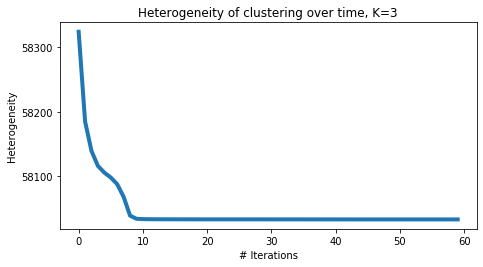

In [69]:
k = 3
heterogeneity = []
initial_centroids = get_initial_centroids(tf_idf, k, seed=0)
centroids, cluster_project = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                       record_heterogeneity=heterogeneity, verbose=True)
plot_heterogeneity(heterogeneity, k)

In [70]:
np.bincount(cluster_project)

array([19595, 10427, 29049])

## Beware of local minima

One weakness of k-means is that it tends to get stuck in a local minimum. To see this, let us run k-means multiple times, with different initial centroids created using different random seeds.

**Note:** Again, in practice, we should set different seeds for every run. We give we a list of seeds for this project so that everyone gets the same answer.

This may take several minutes to run.

In [71]:
k = 10
heterogeneity = {}
cluster_project_dict = {}
import time
start = time.time()
for seed in [0, 20000, 40000, 60000, 80000, 100000, 120000]:
    initial_centroids = get_initial_centroids(tf_idf, k, seed)
    centroids, cluster_project = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_project)

    cluster_project_dict[seed] = np.bincount(cluster_project)
    
#    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
    # And this is the modified print statement
    print('seed={0:06d}, heterogeneity={1:.5f}, cluster_distribution={2}'.format(seed, heterogeneity[seed], 
                                           cluster_project_dict[seed]))
    sys.stdout.flush()
end = time.time()
print(end-start)

seed=000000, heterogeneity=57457.52442, cluster_distribution=[18047  3824  5671  6983  1492  1730  3882  3449  7139  6854]
seed=020000, heterogeneity=57533.20100, cluster_distribution=[ 3142   768  3566  2277 15779  7278  6146  7964  6666  5485]
seed=040000, heterogeneity=57512.69257, cluster_distribution=[ 5551  6623   186  2999  8487  3893  6807  2921  3472 18132]
seed=060000, heterogeneity=57466.97925, cluster_distribution=[ 3014  3089  6681  3856  8080  7222  3424   424  5381 17900]
seed=080000, heterogeneity=57494.92990, cluster_distribution=[17582  1785  7215  3314  6285   809  5930  6791  5536  3824]
seed=100000, heterogeneity=57484.42210, cluster_distribution=[ 6618  1337  6191  2890 16969  4983  5242  3892  5562  5387]
seed=120000, heterogeneity=57554.62410, cluster_distribution=[ 6118  5841  4964  8423  4302  3183 16481  1608  5524  2627]
134.2908091545105


Notice the variation in heterogeneity for different initializations. This indicates that k-means sometimes gets stuck at a bad local minimum.

In [72]:
cluster_project_dict

{0: array([18047,  3824,  5671,  6983,  1492,  1730,  3882,  3449,  7139,
         6854]),
 20000: array([ 3142,   768,  3566,  2277, 15779,  7278,  6146,  7964,  6666,
         5485]),
 40000: array([ 5551,  6623,   186,  2999,  8487,  3893,  6807,  2921,  3472,
        18132]),
 60000: array([ 3014,  3089,  6681,  3856,  8080,  7222,  3424,   424,  5381,
        17900]),
 80000: array([17582,  1785,  7215,  3314,  6285,   809,  5930,  6791,  5536,
         3824]),
 100000: array([ 6618,  1337,  6191,  2890, 16969,  4983,  5242,  3892,  5562,
         5387]),
 120000: array([ 6118,  5841,  4964,  8423,  4302,  3183, 16481,  1608,  5524,
         2627])}

One effective way to counter this tendency is to use **k-means++** to provide a smart initialization. This method tries to spread out the initial set of centroids so that they are not too close together. It is known to improve the quality of local optima and loour average runtime.

In [73]:
def smart_initialize(data, k, seed=None):
    '''Use k-means++ to initialize a good set of centroids'''
    if seed is not None: # useful for obtaining consistent results
        np.random.seed(seed)
    centroids = np.zeros((k, data.shape[1]))
    
    # Randomly choose the first centroid.
    # Since we have no prior knowledge, choose uniformly at random
    idx = np.random.randint(data.shape[0])
    centroids[0] = data[idx,:].toarray()
    # Compute distances from the first centroid chosen to all the other data points
    squared_distances = pairwise_distances(data, centroids[0:1], metric='euclidean').flatten()**2
    
    for i in range(1, k):
        # Choose the next centroid randomly, so that the probability for each data point to be chosen
        # is directly proportional to its squared distance from the nearest centroid.
        # Roughtly speaking, a new centroid should be as far as from ohter centroids as possible.
        idx = np.random.choice(data.shape[0], 1, p=squared_distances/sum(squared_distances))
        centroids[i] = data[idx,:].toarray()
        # Now compute distances from the centroids to all data points
        squared_distances = np.min(pairwise_distances(data, centroids[0:i+1], metric='euclidean')**2,axis=1)
    
    return centroids

Let's now rerun k-means with 10 clusters using the same set of seeds, but always using k-means++ to initialize the algorithm.

This may take several minutes to run.

In [74]:
%%time 

k = 10
heterogeneity_smart = {}
seeds = [0, 20000, 40000, 60000, 80000, 100000, 120000]
for seed in seeds:
    initial_centroids = smart_initialize(tf_idf, k, seed)
    centroids, cluster_project = kmeans(tf_idf, k, initial_centroids, maxiter=400,
                                           record_heterogeneity=None, verbose=False)
    # To save time, compute heterogeneity only once in the end
    heterogeneity_smart[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_project)
    print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity_smart[seed]))
    sys.stdout.flush()


seed=000000, heterogeneity=57468.63808
seed=020000, heterogeneity=57486.94263
seed=040000, heterogeneity=57454.35926
seed=060000, heterogeneity=57530.43659
seed=080000, heterogeneity=57454.51852
seed=100000, heterogeneity=57471.56674
seed=120000, heterogeneity=57523.28839
CPU times: user 2min 37s, sys: 5.27 s, total: 2min 42s
Wall time: 2min 41s


Let's compare the set of cluster heterogeneities we got from our 7 restarts of k-means using random initialization compared to the 7 restarts of k-means using k-means++ as a smart initialization.

The following code produces a [box plot](http://matplotlib.org/api/pyplot_api.html) for each of these methods, indicating the spread of values produced by each method.

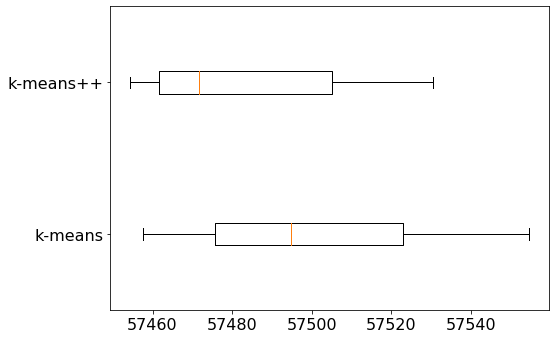

In [75]:
plt.figure(figsize=(8,5))
plt.boxplot([list(heterogeneity.values()), list(heterogeneity_smart.values())], vert=False)
plt.yticks([1, 2], ['k-means', 'k-means++'])
plt.rcParams.update({'font.size': 16})
plt.tight_lawet()

A few things to notice from the box plot:
* On average, k-means++ produces a better clustering than Random initialization.
* Variation in clustering quality is smaller for k-means++.

**In general, we should run k-means at least a few times with different initializations and then return the run resulting in the lowest heterogeneity.** Let us write a function that runs k-means multiple times and picks the best run that minimizes heterogeneity. The function accepts an optional list of seed values to be used for the multiple runs; if no such list is provided, the current UTC time is used as seed values.

In [79]:
def kmeans_multiple_runs(data, k, maxiter, num_runs, seed_list=None, verbose=False):
    heterogeneity = {}
    
    min_heterogeneity_achieved = float('inf')
    best_seed = None
    final_centroids = None
    final_cluster_project = None
    
    for i in range(num_runs):
        
        # Use UTC time if no seeds are provided 
        if seed_list is not None: 
            seed = seed_list[i]
            np.random.seed(seed)
        else: 
            seed = int(time.time())
            np.random.seed(seed)
        
        # Use k-means++ initialization
    
        initial_centroids = smart_initialize(data,k,seed)
        
        # Run k-means
        
        centroids, cluster_project = kmeans(data, k, initial_centroids, maxiter,
                                               record_heterogeneity=None, verbose=False)
        
        # To save time, compute heterogeneity only once in the end
        
        heterogeneity[seed] = compute_heterogeneity(tf_idf, k, centroids, cluster_project)
        
        if verbose:
            print('seed={0:06d}, heterogeneity={1:.5f}'.format(seed, heterogeneity[seed]))
            sys.stdout.flush()
        
        # if current measurement of heterogeneity is loour than previously seen,
        # update the minimum record of heterogeneity.
        if heterogeneity[seed] < min_heterogeneity_achieved:
            min_heterogeneity_achieved = heterogeneity[seed]
            best_seed = seed
            final_centroids = centroids
            final_cluster_project = cluster_project
    
    # Return the centroids and cluster projects that minimize heterogeneity.
    return final_centroids, final_cluster_project

## How to choose K

Since we are measuring the tightness of the clusters, a higher value of K reduces the possible heterogeneity metric by definition.  For example, if we have N data points and set K=N clusters, then we could have 0 cluster heterogeneity by setting the N centroids equal to the values of the N data points. (Note: Not all runs for larger K will result in loour heterogeneity than a single run with smaller K due to local optima.)  Let's explore this general trend for ourselves by performing the following analysis.

Use the `kmeans_multiple_runs` function to run k-means with five different values of K.  For each K, use k-means++ and multiple runs to pick the best solution.  In what follows, we consider K=2,10,25,50,100 and 7 restarts for each setting.

**IMPORTANT: The code block below will take about 10 minutes to finish**

In order to speed up the computations, we run them with only one random seed, but for better performance, one should use more seeds and compare the results. If we don't mind running the code for approximately one hour, feel free to uncomment the following line of code below:

`seed_list = [0]#, 20000, 40000, 60000, 80000, 100000, 120000]`

Side note: In practice, a good implementation of k-means would utilize parallelism to run multiple runs of k-means at once. For an example, see [scikit-learn's KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

In [80]:
%%time
import numpy as np 

def plot_k_vs_heterogeneity(k_values, heterogeneity_values):
    plt.figure(figsize=(7,4))
    plt.plot(k_values, heterogeneity_values, linewidth=4)
    plt.xlabel('K')
    plt.ylabel('Heterogeneity')
    plt.title('K vs. Heterogeneity')
    plt.rcParams.update({'font.size': 16})
    plt.tight_lawet()

centroids = {}
cluster_project = {}
heterogeneity_values = []
k_list = [2, 10, 25, 50, 100]
seed_list = [0]
# Uncomment the following line to run the plot with all the seeds (it may take about an hour to finish).
#seed_list = [0, 20000, 40000, 60000, 80000, 100000, 120000]

for k in k_list:
    heterogeneity = []
    centroids[k], cluster_project[k] = kmeans_multiple_runs(tf_idf, k, maxiter=400,
                                                               num_runs=len(seed_list),                                                               seed_list=seed_list,
                                                               verbose=True)
    score = compute_heterogeneity(tf_idf, k, centroids[k], cluster_project[k])
    heterogeneity_values.append(score)

seed=000000, heterogeneity=58224.59913
seed=000000, heterogeneity=57468.63808
seed=000000, heterogeneity=56913.24052
seed=000000, heterogeneity=56399.72145
seed=000000, heterogeneity=55649.66538
CPU times: user 5min 42s, sys: 32.4 s, total: 6min 14s
Wall time: 6min 11s


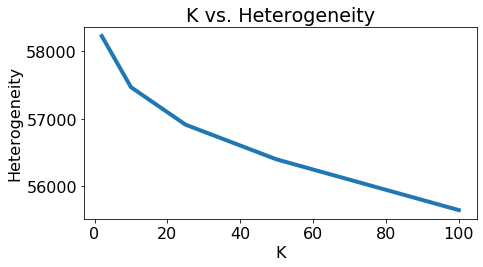

In [81]:
plot_k_vs_heterogeneity(k_list, heterogeneity_values)

In the above plot we show that heterogeneity goes down as we increase the number of clusters. Does this mean we should always favor a higher K? **Not at all!** As we will see in the following section, setting K too high may end up separating data points that are actually pretty alike. At the extreme, we can set individual data points to be their own clusters (K=N) and achieve zero heterogeneity, but separating each data point into its own cluster is hardly a desirable outcome. In the following section, we will learn how to detect a K set "too large".

## Visualize clusters of documents

Let's start visualizing some clustering results to see if we think the clustering makes sense.  We can use such visualizations to help us assess whether we have set K too large or too small for a given application.  Following the theme of this course, we will judge whether the clustering makes sense in the context of document analysis.

What are we looking for in a good clustering of documents?
* Documents in the same cluster should be similar.
* Documents from different clusters should be less similar.

So a bad clustering exhibits either of two symptoms:
* Documents in a cluster have mixed content.
* Documents with similar content are divided up and put into different clusters.

To help visualize the clustering, we do the following:
* Fetch nearest neighbors of each centroid from the set of documents assigned to that cluster. We will consider these documents as being representative of the cluster.
* Print titles and first sentences of those nearest neighbors.
* Print top 5 words that have highest tf-idf weights in each centroid.

In [82]:
def visualize_document_clusters(wiki, tf_idf, centroids, cluster_project, k, map_word_to_index, display_content=True):
    '''wiki: original dataframe
       tf_idf: data matrix, sparse matrix format
       map_index_to_word: SFrame specifying the mapping betweeen words and column indices
       display_content: if True, display 8 nearest neighbors of each centroid'''
    map_index_to_word =  {v:k for k,v in map_word_to_index.items()}
    print('==========================================================')
    # Visualize each cluster c
    for c in range(k):
        # Cluster heading
        print('Cluster {0:d}    '.format(c)),
        # Print top 5 words with largest TF-IDF weights in the cluster
        idx = centroids[c].argsort()[::-1]
        for i in range(5): # Print each word along with the TF-IDF weight
            print('{0:s}:{1:.3f}'.format(map_index_to_word[idx[i]], centroids[c][idx[i]])),
        print('')
        
        if display_content:
            # Compute distances from the centroid to all data points in the cluster,
            # and compute nearest neighbors of the centroids within the cluster.
            distances = pairwise_distances(tf_idf, centroids[c].reshape(1, -1), metric='euclidean').flatten()
            distances[cluster_project!=c] = float('inf') # remove non-members from consideration
            
            nearest_neighbors = distances.argsort()
            
            # For 8 nearest neighbors, print the title as well as first 180 characters of text.
            # Wrap the text at 80-character mark.
            for i in range(8):
                text = ' '.join(wiki[nearest_neighbors[i]]['text'].split(None, 25)[0:25])
                print('\n* {0:50s} {1:.5f}\n  {2:s}\n  {3:s}'.format(wiki[nearest_neighbors[i]]['name'],
                    distances[nearest_neighbors[i]], text[:90], text[90:180] if len(text) > 90 else ''))
        print('==========================================================')

Let us first look at the 2 cluster case (K=2).

In [83]:
'''Notice the extra pairs of parentheses for centroids and cluster_project.
   The centroid and cluster_project are still inside the npz file,
   and we need to explicitly indicate when to load them into memory.'''
visualize_document_clusters(wiki, tf_idf, centroids[2], cluster_project[2], 2, map_index_to_word)

Cluster 0    
she:0.021
university:0.015
her:0.013
he:0.012
served:0.010


* Kayee Griffin                                      0.97358
  kayee frances griffin born 6 february 1950 is an australian politician and former australi
  an labor party member of the new south wales legislative council serving

* %C3%81ine Hyland                                   0.97370
  ine hyland ne donlon is emeritus professor of education and former vicepresident of univer
  sity college cork ireland she was born in 1942 in athboy co

* Christine Robertson                                0.97373
  christine mary robertson born 5 october 1948 is an australian politician and former austra
  lian labor party member of the new south wales legislative council serving

* Anita Kunz                                         0.97471
  anita e kunz oc born 1956 is a canadianborn artist and illustratorkunz has lived in london
   new york and toronto contributing to magazines and working

* Barry Sullivan (lawyer)    

Both clusters have mixed content, although cluster 1 is much purer than cluster 0:
* Cluster 0: academia, law
* Cluster 1: female figures, baseball players

Roughly speaking, the entire dataset was divided into athletes and non-athletes. It would be better if we sub-divided non-atheletes into more categories. So let us use more clusters. How about `K=10`?

In [84]:
k = 10
visualize_document_clusters(wiki, tf_idf, centroids[k], cluster_project[k], k, map_index_to_word)

Cluster 0    
he:0.012
art:0.011
his:0.009
book:0.008
that:0.008


* Wilson McLean                                      0.97661
  wilson mclean born 1937 is a scottish illustrator and artist he has illustrated primarily 
  in the field of advertising but has also provided cover art

* Tang Xiyang                                        0.97988
  tang xiyang born january 30 1930 in miluo hunan province is a chinese environmentalist he 
  was awarded the 2007 ramon magsaysay award for peace and

* David Salle                                        0.98168
  david salle born 1952 is an american painter printmaker and stage designer who helped defi
  ne postmodern sensibility salle was born in norman oklahoma he earned

* Alberto Blanco (poet)                              0.98172
  alberto blanco is considered one of mexicos most important poets born in mexico city on fe
  bruary 18 1951 he spent his childhood and adolescence in

* John Donald (jewellery designer)                   0.98290



* Daniel Meyer (conductor)                           0.90849
  daniel meyer was born in cleveland ohio and has been conductor and musical director of sev
  eral prominent american orchestrashe is a graduate of denison university

* Paul Hostetter                                     0.90967
  paul hostetter is the ethel foley distinguished chair in orchestral activities for the sch
  wob school of music at columbus state university the conductor and artistic

* Peter Ruzicka                                      0.91097
  peter ruzicka born july 3 1948 is a german composer and conductor of classical musicpeter 
  ruzicka was born in dsseldorf on july 3 1948 he
Cluster 5    
she:0.140
her:0.088
miss:0.012
actress:0.011
womens:0.011


* Lauren Royal                                       0.93427
  lauren royal born march 3 circa 1965 is a book writer from california royal has written bo
  th historic and novelistic booksa selfproclaimed angels baseball fan

* Janine Shepherd               


* Timothy Luke                                       0.96028
  timothy w luke is university distinguished professor of political science in the college o
  f liberal arts and human sciences as well as program chair of

* Ren%C3%A9e Fox                                     0.96119
  rene c fox a summa cum laude graduate of smith college in 1949 earned her phd in sociology
   in 1954 from radcliffe college harvard university

* Francis Gavin                                      0.96213
  francis j gavin is first frank stanton chair in nuclear security policy studies and profes
  sor of political science at mit before joining mit he was

* Catherine Hakim                                    0.96358
  catherine hakim born 30 may 1948 is a british sociologist who specialises in womens employ
  ment and womens issues she is currently a professorial research fellow

* Daniel Berg (educator)                             0.96361
  daniel berg is a scientist educator and was the fifteenth presiden

Clusters 0, 1, and 5 appear to be still mixed, but others are quite consistent in content.
* Cluster 0: artists, book, him/his
* Cluster 1: film, theatre, films, tv, actor 
* Cluster 2: baseball players
* Cluster 3: elections, ministers
* Cluster 4: music, orchestra, symphony 
* Cluster 5: female figures from various fields
* Cluster 6: composers, songwriters, singers, music producers
* Cluster 7: law, courts, justice 
* Cluster 8: football 
* Cluster 9: academia

Clusters are now more pure, but some are qualitatively "bigger" than others. For instance, the category of scholars is more general than the category of baseball players. Increasing the number of clusters may split larger clusters. Another way to look at the size of the clusters is to count the number of articles in each cluster.

In [85]:
np.bincount(cluster_project[10])

array([19618,  3857,  4173,  5219,  1743,  6900,  5530,  1348,  4384,
        6299])

There appears to be at least some connection between the topical consistency of a cluster and the number of its member data points.

Let us visualize the case for K=25. For the sake of brevity, we do not print the content of documents. It turns out that the top words with highest TF-IDF weights in each cluster are representative of the cluster.

In [86]:
visualize_document_clusters(wiki, tf_idf, centroids[25], cluster_project[25], 25,
                            map_index_to_word, display_content=False) # turn off text for brevity

Cluster 0    
poetry:0.053
novel:0.043
book:0.042
published:0.039
fiction:0.034

Cluster 1    
film:0.100
theatre:0.039
films:0.036
directed:0.029
actor:0.028

Cluster 2    
law:0.143
court:0.087
judge:0.066
district:0.045
justice:0.042

Cluster 3    
republican:0.061
senate:0.050
district:0.044
state:0.039
democratic:0.037

Cluster 4    
music:0.114
piano:0.047
orchestra:0.039
composition:0.038
composer:0.034

Cluster 5    
album:0.116
released:0.058
her:0.056
single:0.046
music:0.040

Cluster 6    
music:0.055
jazz:0.038
album:0.028
song:0.020
records:0.019

Cluster 7    
board:0.028
business:0.027
economics:0.026
chairman:0.025
president:0.025

Cluster 8    
he:0.011
his:0.009
that:0.009
world:0.007
book:0.007

Cluster 9    
research:0.050
university:0.039
professor:0.038
science:0.030
institute:0.021

Cluster 10    
foreign:0.075
ambassador:0.063
affairs:0.057
security:0.044
nations:0.042

Cluster 11    
baseball:0.110
league:0.103
major:0.052
games:0.047
season:0.045

Cluster 12  

Looking at the representative examples and top words, we classify each cluster as follows.

* Cluster 0: Literature
* Cluster 1: Film and theater
* Cluster 2: Law
* Cluster 3: Politics
* Cluster 4: Classical music
* Cluster 5: Popular music
* Cluster 6: Jazz music
* Cluster 7: Business and economics
* Cluster 8: (mixed; no clear theme)
* Cluster 9: Academia and research
* Cluster 10: International affairs
* Cluster 11: Baseball
* Cluster 12: Art
* Cluster 13: Military
* Cluster 14: Politics
* Cluster 15: Radio and TV
* Cluster 16: Catholic church
* Cluster 17: Opera and ballet
* Cluster 18: Orchestra music
* Cluster 19: Females from various fields
* Cluster 20: Car racing
* Cluster 21: General sports
* Cluster 22: Rugby
* Cluster 23: Rock music
* Cluster 24: Team sports

Indeed, increasing K achieved the desired effect of breaking up large clusters.  Depending on the application, this may or may not be preferable to the K=10 analysis.

Let's take it to the extreme and set K=100. We have a suspicion that this value is too large. Let us look at the top words from each cluster:

In [88]:
k=100
visualize_document_clusters(wiki, tf_idf, centroids[k], cluster_project[k], k,
                            map_index_to_word, display_content=True)
# turn off text for brevity -- turn it on if we are curious ;)

Cluster 0    
psychology:0.195
psychological:0.066
research:0.057
psychologist:0.045
cognitive:0.041


* Richard John Crisp                                 0.84670
  richard john crisp born 6 november 1973 a social psychologist is professor of psychology a
  t the university of kent centre for the study of group

* David Myers (academic)                             0.85932
  david guy myers born 20 september 1942 is a professor of psychology at hope college in mic
  higan united states and the author of 17 books

* Barbara Tversky                                    0.87266
  barbara tversky is a professor emerita of psychology at stanford university and a professo
  r of psychology and education at teachers college columbia university tversky specializes

* E. Mark Stern                                      0.88477
  e mark stern born 1929 is a humanisticexistential psychologist who holds an master of scie
  nce ms degree from the pennsylvania state university 1953 and a

* Jefferson F


* Scott Perkins                                      0.93191
  scott perkins is an international prizewinning composer a tenor an awardwinning scholar an
  d a music educator his music includes art songs musical theatre solo instrumental

* Jane W. Davidson                                   0.93198
  jane davidson is a british musicologist and professor of creative and performing arts musi
  c in the faculty of the victorian college of the arts and
Cluster 5    
album:0.108
her:0.078
billboard:0.075
chart:0.072
singles:0.067


* Kelly Clarkson                                     0.87615
  kelly brianne clarkson born april 24 1982 is an american singer and songwriter in 2002 she
   rose to fame after winning the first season of

* Joss Stone                                         0.87751
  jocelyn eve stoker born 11 april 1987 better known by her stage name joss stone is an engl
  ish soul singersongwriter and actress stone rose to

* Adele                                             


* V. K. Singh                                        0.95022
  general vijay kumar singh pvsm avsm ysm born 10 may 1951 is an indian politician and retir
  ed military officer he was appointed as the minister

* Basudeb Acharia                                    0.95213
  basudeb acharia born 11 july 1942 is an indian politician and a leader of the communist pa
  rty of india marxist political party his family originally

* Piyush Goyal                                       0.95233
  piyush goyal is the honble minister of state with independent charge for power coal and ne
  w renewable energy in the government of india he is
Cluster 10    
czech:0.207
prague:0.124
republic:0.046
czechoslovakia:0.032
vclav:0.021


* Petr H%C3%A1jek                                    0.86311
  petr hjek born 6 february 1940 in prague czech pronunciation ptr ajk is a czech scientist 
  in the area of mathematical logic and a professor

* Bohumil Dole%C5%BEal                               0.90130
  bohum


* Donna Petrovich                                    0.90638
  donnalee petrovich born 15 november 1963 is an australian politician she was a liberal par
  ty of australia member of the victorian legislative council from 2006

* Judy Spence                                        0.90761
  judith caroline spence born 19 may 1957 is an australian politician and former member of t
  he legislative assembly of queensland for the australian labor party

* Ann Barker                                         0.90879
  ann patricia barker born 19 january 1952 is a former australian politician she was an aust
  ralian labor party member of the victorian legislative assembly from

* Jon Sullivan                                       0.90881
  jonathan harold jon sullivan born 10 november 1950 an australian politician was a member o
  f the australian house of representatives from 2007 to 2010 representing

* Annette Ellis                                      0.90900
  annette louise ellis born 1


* Thomas Piercy                                      0.94241
  thomas piercy born 1957 is an american clarinetist based in new york city and tokyo japan 
  although he studied in the united states his playing
Cluster 19    
book:0.045
books:0.032
published:0.027
editor:0.025
magazine:0.021


* Chris Hunt                                         0.96351
  chris hunt is a british journalist magazine editor and author he has worked in journalism 
  for over twenty years most often writing about football or

* Pamela Paul                                        0.96609
  pamela paul is the editor of the new york times book review she joined the times in 2011 a
  nd served as childrens books editor and

* Richard Locke                                      0.96666
  richard locke is a critic and essayisthe received a ba from columbia college columbia univ
  ersity a ba from clare college cambridge university and did graduate

* James Traub                                        0.96764
  jame


* Nina Vidal                                         0.94711
  nina simone vidal born april 20 is an american singersongwriter and pianist known best by 
  her stage name nina vidalin 2008 vidal released her selftitled

* Mark de Clive-Lowe                                 0.94722
  mark de clivelowe is a musician composer and producer originally from new zealand and now 
  based in los angeles california since 2009 after ten years
Cluster 24    
football:0.054
cup:0.048
club:0.045
team:0.039
league:0.036


* Michael Owen                                       0.94176
  michael james owen born 14 december 1979 is an english former footballer who played as a s
  triker for liverpool real madrid newcastle united manchester united

* Gianluca Vialli                                    0.94223
  gianluca vialli born 9 july 1964 in cremona is an italian football manager and former play
  er since retiring he has gone into management and punditry

* Fernando Torres                             


* Alpha Kanu                                         0.81800
  alhaji alpha sahid bakar kanu is a sierra leonean politician and the current sierra leone 
  minister of presidential and public affairs he is also the

* Ahmad Tejan Sillah                                 0.81994
  ahmad tejan sillah is a sierra leonean islamic preacher and the chief imam of the freetown
   central mosque the largest mosque in sierra leone he

* Julius Maada Bio                                   0.82519
  brigadier ret julius maada wonie bio born may 12 1964 is a sierra leonean politician who w
  as the military head of state of sierra leone

* Usman Boie Kamara                                  0.84467
  alhaji usman boie kamara is a sierra leonean politician businessman and mining engineer he
   is currently sierra leone minister of trade and industry he is

* Joseph Opala                                       0.84545
  joseph a opala born august 4 1950 is an american historian noted for establishing the


* Michael Silverstein                                0.89893
  michael silverstein born 1945 is a professor of anthropology linguistics and psychology at
   the university of chicago he is a theoretician of semiotics and linguistic

* Mary Dalrymple                                     0.89994
  mary dalrymple born march 9 1954 is a professor of linguistics at oxford university at oxf
  ord she is a fellow of linacre college prior to

* William G. Eggington                               0.90158
  william gregory bill eggington born 1950 is ludwigwebersiebach humanities professor 201320
  18 in the linguistics and english language department college of humanities at brigham you

* Gregory Guy                                        0.90175
  gregory r guy is a linguist who specializes in the study of language variation and languag
  e diversity including sociolinguistics historical linguistics phonetics and phonology he
Cluster 33    
economics:0.150
economic:0.098
economist:0.053
policy


* Avner Friedman                                     0.87188
  avner friedman born november 19 1932 is distinguished professor of mathematics and physica
  l sciences at ohio state university his primary field of research is partial

* Jonathan Borwein                                   0.89330
  jonathan michael borwein born 20 may 1951 st andrews scotland is a scottish mathematician 
  who holds an appointment as laureate professor of mathematics at the

* John Toland (mathematician)                        0.90241
  john francis toland frs frse born 28 april 1949 derry is an irish mathematician based in t
  he uk he is currently director of the isaac

* Paul Ernest                                        0.90522
  paul ernest born 1944 is a contributor to the social constructivist see social constructiv
  ism philosophy of mathematics ernests philosophical sources are the later works of

* Asghar Qadir                                       0.90663
  asghar qadir urdu 23 july 1946 hi s


* James Nesbitt                                      0.95552
  james nesbitt born 15 january 1965 is an actor presenter and comedian from northern irelan
  d born in ballymena county antrim nesbitt grew up in the

* Bryan Cranston                                     0.95562
  bryan lee cranston born march 7 1956 is an american actor voice actor screenwriter directo
  r and producer he is known for portraying walter white in
Cluster 42    
football:0.120
afl:0.113
australian:0.083
season:0.058
club:0.058


* Scott McMahon                                      0.86094
  scott mcmahon born 2 june 1986 is an australian rules football player currently on the ros
  ter of australian football league afl club north melbourne kangaroosmcmahon

* Sam Hunt (Australian footballer)                   0.86443
  samuel sam hunt born 13 april 1983 is an australian rules footballer who has played for es
  sendon in the australian football league afl geelong and

* Richard Ambrose                        


* Craig Perret                                       0.91078
  craig perret born february 2 1951 in new orleans louisiana is an american thoroughbred hor
  se racing jockey he began riding horses at age five and

* Lloyd Duffy                                        0.91129
  lloyd duffy born december 8 1944 in charlottetown prince edward island is a retired canadi
  an champion jockey in thoroughbred flat horse racing who uniquely is

* Jorge Vel%C3%A1squez                               0.91208
  jorge velsquez born december 28 1946 in chepo panama is a thoroughbred horse racing hall o
  f fame jockeyjorge velasquez career in thoroughbred racing began in

* Larry Snyder                                       0.91216
  larry lloyd snyder born june 29 1942 in toledo ohio is a retired american thoroughbred hor
  se racing jockey whose career spanned thirtyfive years from 1960
Cluster 47    
archaeology:0.281
archaeological:0.114
ancient:0.072
archaeologist:0.059
excavations:0.055


* Dan 


* Jeff McEnery                                       0.87880
  jeff mcenery is a canadian comedian born and raised in the small town of acton ontario he 
  graduated from humber colleges comedy writing and performance

* Debra DiGiovanni                                   0.90743
  debra digiovanni is a canadian standup comedian of italian descent originally from tillson
  burg ontarioher comedy career began with the help of humber colleges inaugural year

* Pete Johansson                                     0.91567
  peter pete johansson born november 6 1973 is a canadian comedian writer and actor he has a
   number of notable television appearances including comedy centrals

* Jeff Klinger                                       0.91670
  jeff klinger is an american comedian who lives in los angeles born in brooklyn ny he atten
  ded school in salt lake city after moving to

* Ronnie Khalil                                      0.92137
  shaher ronnie khalil born september 1977 is an am


* Jerry L. Martin                                    0.95204
  jerry l martin is chairman emeritus of the american council of trustees and alumni he serv
  ed as president of acta from its founding in 1995

* Archie Brown                                       0.95226
  archibald haworth brown cmg fba commonly known as archie brown born 10 may 1938 is a briti
  sh political scientist and historian in 2005 he became

* Shannon C. Stimson                                 0.95266
  shannon c stimson born october 8 1951 is an american political theorist philosopher and hi
  storian of ideas whose work and teaching spans the economic and

* Paul Russell (philosopher)                         0.95402
  paul russell born 1955 is a professor in philosophy at the university of british columbia 
  where he has been teaching since 1987he has been a
Cluster 56    
food:0.260
cooking:0.049
she:0.038
cookbook:0.031
culinary:0.028


* Joanna Blythman                                    0.82962
  joanna 


* James Canton                                       0.95821
  james canton born april 29 1951 is a futurist author entrepreneur ceo chairman of the inst
  itute for global futures he forecasts global trends in business

* George Yip                                         0.96050
  george yip is a research specialist in global strategy and marketing and professor of mana
  gement and codirector centre on china innovation at china europe international

* John Caslione                                      0.96155
  john a caslione born buffalo new york is an american investment advisor consultant profess
  or author public speaker and entrepreneurcaslione is a global business strategy expert

* Gina O'Connor                                      0.96529
  dr gina colarelli oconnor is associate professor in the lally school of management technol
  ogy at rensselaer polytechnic institute where she has taught and conducted research

* Robert J. Dolan (educator)                         0.96


* Mike Embley                                        0.85787
  mike embley born 1955 in surrey england is a broadcast journalist best known as a presente
  r for bbc world news an international news and current

* John Forrest (producer)                            0.86143
  references songs of praisearticle in the jewish chronicles re the insight film festivaljoh
  nforresttvjohn forrest is a uk production creative who has made significant contributions 
Cluster 65    
army:0.078
command:0.078
commander:0.078
military:0.074
staff:0.059


* Claude M. Kicklighter                              0.89188
  claude m kicklighter born august 22 1933 is a retired american army lieutenant general he 
  is a former commander of the united states army western

* Johnnie H. Corns                                   0.89568
  john herman corns born march 21 1936 was a lieutenant general in the united states army wh
  o served as commander of united states army pacific

* Robert Mark Brown              


* Sun Zhongtong                                      0.91276
  sun zhongtong chinese october 1944 is a general of the peoples liberation army pla of the 
  peoples republic of china and the current vice director

* Somsak Kiatsuranont                                0.91423
  somsak kiatsuranont thai born 27 june 1954 in khon kaen is a thai politician pheu thai par
  ty he has been serving as the speaker of

* Peng Qinghua                                       0.91567
  peng qinghua simplified chinese traditional chinese pinyin png qnghu born april 1957 is a 
  politician of the peoples republic of china he has been the

* Li Jingtian                                        0.91802
  li jingtian chinese january 1948 is of manchu ethnicity and a politician of the peoples re
  public of china he is currently the executive vice president
Cluster 70    
miss:0.358
pageant:0.206
usa:0.122
she:0.111
her:0.063


* Tanya Wilson                                       0.69171
  tanya wilson born j


* Kevin Nicholson (baseball)                         0.87178
  kevin ronald nicholson born march 29 1976 is a canadian baseball shortstop he played part 
  of the 2000 season for the san diego padres of

* Chris Roberts (baseball)                           0.87371
  christopher eric roberts born june 25 1971 is a retired professional baseball pitcherrober
  ts attended middleburg high school in middleburg florida he competed for the united

* Ruth Born                                          0.87776
  ruth born born august 8 1925 is a former pitcher who played in the allamerican girls profe
  ssional baseball league listed at 5 ft 3 in

* Earl Agnoly                                        0.88025
  earl rene agnoly thompson born november 18 1975 in coln panama is a former professional ba
  seball player who is most notable for being on panamas

* Doris Cook                                         0.88152
  doris cook little cookie born june 23 1931 is a former pitcher and outfielder 


* Forrest Howard McDonald                            0.93552
  forrest howard mcdonald born april 22 1950 is an american blues rock musician who has writ
  ten hundreds of songs and played on many recordsforrest howard

* Elmore D                                           0.93679
  elmore d born daniel droixhe 1946 near lige belgium is a belgian blues musician his is als
  o a professor at the university of lige where

* Rick Estrin & The Nightcats                        0.94104
  rick estrin the nightcats are an american fourpiece electric blues band formed in 2008 aft
  er the dissolution of little charlie the nightcats of which three

* Guido van Rijn                                     0.94193
  guido van rijn 11 april 1950 is a dutch blues and gospel historianvan rijn received his ph
  d from leiden university in 1995 for roosevelts blues
Cluster 79    
marathon:0.064
olympics:0.059
championships:0.057
olympic:0.055
she:0.041


* Mizuki Noguchi                                    


* Lucienne Robillard                                 0.89930
  lucienne robillard pc born june 16 1945 is a canadian politician and a member of the liber
  al party of canada she sat in the house

* Marcelle Mersereau                                 0.90078
  marcelle mersereau born february 14 1942 in pointeverte new brunswick is a canadian politi
  cian a civil servant for most of her career she also served

* Muriel Smith                                       0.90161
  muriel ann smith oc born may 9 1930 is a manitoba politician she ran for the leadership of
   the new democratic party of manitoba in

* Greg Thompson                                      0.90508
  gregory francis thompson pc mp born march 28 1947 in st stephen new brunswick is a canadia
  n politician who served six terms as an mpthompson

* Marianne Cerilli                                   0.90672
  marianne cerilli born 1961 is a politician in manitoba canada she served as a new democrat
  ic member of the manito


* Andy Cottam                                        0.87384
  andrew colin cottam born 14 july 1973 in northampton england was an english cricketer he w
  as a righthanded batsman and a leftarm slow bowler he

* Gamini Silva                                       0.87547
  mangamuni gamini silva born 19 december 1960 is a sri lankan firstclass cricketer and test
   cricket umpiresilva was born in colombo and became a policeman
Cluster 88    
runs:0.116
league:0.100
baseball:0.089
batted:0.067
home:0.064


* Jerry Keller (baseball)                            0.86384
  charles bricker keller born february 9 1955 in royal oak michigan is a former minor league
   baseball first baseman catcher and designated hitter who played

* Dan Peltier                                        0.87195
  daniel edward peltier born june 30 1968 in clifton park new york is a former professional 
  baseball player a lefthanded outfielder who also played some

* Jeff Abbott (baseball)                        


* Enrique Molina (athlete)                           0.83126
  enrique molina vargas born 25 february 1968 is a retired spanish runner who specialized in
   the 5000 metreshe was born in la zubia he won

* Antonina Yefremova                                 0.83309
  antonina yefremova born 19 july 1981 is a ukrainian sprinter who specializes in the 400 me
  tres yefremova received a twoyear ban in 2012 for using

* Gwen Griffiths                                     0.83677
  gwendolien gwen griffiths born 30 august 1967 is a retired south african runner who specia
  lized in the 1500 and 5000 metres later the marathonshe was

* Shitaye Eshete                                     0.83809
  shitaye eshete habtegebrel born 21 may 1990 is an ethiopianborn longdistance runner who co
  mpetes internationally for bahrainshe first began competing for the oilrich gulf state

* Tejitu Daba                                        0.83879
  tejitu daba chalchissa born 20 august 1991 is an ethiopian


* Bruce Cohen                                        0.96300
  bruce l cohen born september 23 1961 is a film television and theater producer he began hi
  s film career as the directors guild of america

* Victor Glynn                                       0.96380
  victor glynn an award winning film and television producer and writer was born in balham l
  ondon on 11 october 1956 he married lorna gillian gill
Cluster 97    
chess:0.416
grandmaster:0.085
olympiad:0.066
championship:0.064
fide:0.059


* James Eade                                         0.69582
  james eade born march 23 1957 is an american chess master chess tournament organizer and c
  hess book publisher he holds the title of fide master

* Raymond Keene                                      0.70983
  raymond dennis keene obe born 29 january 1948 is an english chess grandmaster a fide inter
  national arbiter a chess organiser and a journalist and authorp196

* William John Donaldson                             0.7

The class of team sports has been broken into several clusters, soccer (association football) (11, 22, 24), rugby (76), hockey (80), basketball (86), cricket (87), and American football (85).

The class of baseball has been broken into San Francisco Giants (45), baseball (61, 74), and baseball stats (88).

The class of car racing has been broken into Nascar (20) and Formula 1 (52).

**A high value of K encourages pure clusters, but we cannot keep increasing K. For large enough K, related documents end up going to different clusters.**

That said, the result for K=100 is not entirely bad. After all, it gives us separate clusters for such categories as Brazil, wrestling, computer science and the Mormon Church. If we set K somewhere between 25 and 100, we should be able to avoid breaking up clusters while discovering new ones.

Also, we should ask ourselves how much **granularity** we want in our clustering. If we wanted a rough sketch of Wikipedia, we don't want too detailed clusters. On the other hand, having many clusters can be valuable when we are zooming into a certain part of Wikipedia.

**There is no golden rule for choosing K. It all depends on the particular application and domain we are in.**

Another heuristic people use that does not rely on so much visualization, which can be hard in many applications (including here!) is as follows.  Track heterogeneity versus K and look for the "elbow" of the curve where the heterogeneity decrease rapidly before this value of K, but then only gradually for larger values of K.  This naturally trades off between trying to minimize heterogeneity, but reduce model complexity.  In the heterogeneity versus K plot made above, we did not yet really see a flattening out of the heterogeneity, which might indicate that indeed K=100 is "reasonable" and we only see real overfitting for larger values of K (which are even harder to visualize using the methods we attempted above.)

 Another sign of too large K is having lots of small clusters. Look at the distribution of cluster sizes (by number of member data points). How many of the 100 clusters have feour than 236 articles, i.e. 0.4% of the dataset?

In [111]:
s = 0
a = np.array(cluster_project[100])
for i in range(100):
    b = a == i
    if np.bincount(b)[1] < 236:
        s += 1
s

33

In [108]:
a = np.array(cluster_project[100])
b = a == 10
np.bincount(b)

array([58973,    98])

### Takeaway

Keep in mind though that tiny clusters aren't necessarily bad. A tiny cluster of documents that really look like each others is definitely preferable to a medium-sized cluster of documents with mixed content. However, having too few articles in a cluster may cause overfitting by reading too much into a limited pool of training data.